In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from random import shuffle
from scipy.spatial import cKDTree
import time
import matplotlib.pyplot as plt
from math import sqrt
import networkx as nx

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from sklearn.utils.class_weight import compute_class_weight

import torch_geometric
import os

import warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#Multi GPU training does not work yet TODO: Fix
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Primary device: {device}")


Primary device: cuda:0


In [4]:
import numpy as np
import torch
from scipy.spatial.distance import pdist, squareform
from random import shuffle

#@title Dataloader definitions
class DotDict(dict):
    """Wrapper around in-built dict class to access members through the dot operation.
    """

    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


class GoogleTSPReader(object):
    """Iterator that reads TSP dataset files and yields mini-batches.

    Modified to identify only the crossover edges (edges connecting different quadrants).

    Format expected as in Vinyals et al., 2015: https://arxiv.org/abs/1506.03134, http://goo.gl/NDcOIG
    """

    def __init__(self, num_nodes, num_neighbors, batch_size, filepath):
        """
        Args:
            num_nodes: Number of nodes in TSP tours
            num_neighbors: Number of neighbors to consider for each node in graph
            batch_size: Batch size
            filepath: Path to dataset file (.txt file)
        """
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.batch_size = batch_size
        self.filepath = filepath
        
        # Read and shuffle the data correctly
        with open(filepath, "r") as f:
            lines = f.readlines()
        shuffle(lines)  # Shuffle the list in place
        self.filedata = lines  # Assign the shuffled list to self.filedata
        
        self.max_iter = (len(self.filedata) // batch_size)

    def __iter__(self):
        for batch in range(self.max_iter):
            start_idx = batch * self.batch_size
            end_idx = (batch + 1) * self.batch_size
            yield self.process_batch(self.filedata[start_idx:end_idx])

    def process_batch(self, lines):
        """Helper function to convert raw lines into a mini-batch as a DotDict.
        Only crossover edges (connecting different quadrants) are set as ground truth.
        """
        batch_edges = []
        batch_edges_values = []
        batch_edges_target = []  # Binary classification targets (0/1) for crossover edges
        batch_nodes = []
        batch_nodes_target = []  # Multi-class classification targets (`num_nodes` classes)
        batch_nodes_coord = []
        batch_tour_nodes = []
        batch_tour_len = []

        for line_num, line in enumerate(lines):
            line = line.strip().split(" ")  # Split into list and remove trailing newline

            # Compute signal on nodes
            nodes = np.ones(self.num_nodes)  # All 1s for TSP...

            # Convert node coordinates to required format
            nodes_coord = []
            for idx in range(0, 2 * self.num_nodes, 2):
                nodes_coord.append([float(line[idx]), float(line[idx + 1])])

            nodes_coord = np.array(nodes_coord)
            batch_nodes_coord.append(nodes_coord)

            # Assign each node to a quadrant
            quadrants = []
            for coord in nodes_coord:
                x, y = coord
                if x >= 0 and y >= 0:
                    quadrants.append(1)  # Quadrant I
                elif x < 0 and y >= 0:
                    quadrants.append(2)  # Quadrant II
                elif x < 0 and y < 0:
                    quadrants.append(3)  # Quadrant III
                else:
                    quadrants.append(4)  # Quadrant IV

            quadrants = np.array(quadrants)

            # Compute distance matrix
            W_val = squareform(pdist(nodes_coord, metric='euclidean'))

            # Compute adjacency matrix
            if self.num_neighbors == -1:
                W = np.ones((self.num_nodes, self.num_nodes))  # Graph is fully connected
            else:
                W = np.zeros((self.num_nodes, self.num_nodes))
                # Determine k-nearest neighbors for each node
                knns = np.argpartition(W_val, kth=self.num_neighbors, axis=-1)[:, :self.num_neighbors]
                # Make connections 
                for idx in range(self.num_nodes):
                    W[idx][knns[idx]] = 1
            np.fill_diagonal(W, 2)  # Special token for self-connections

            # Convert tour nodes to required format
            # Assuming 'output' is a keyword in the line indicating the start of tour nodes
            try:
                output_idx = line.index('output')
                tour_nodes = [int(node) - 1 for node in line[output_idx + 1:]][:-1]  # Removed redundant slicing
            except ValueError:
                raise ValueError("Line does not contain 'output' keyword to indicate tour nodes.")

            batch_tour_nodes.append(tour_nodes)

            # Compute node and edge representation of tour + tour_len
            tour_len = 0
            nodes_target = np.zeros(self.num_nodes)
            edges_target = np.zeros((self.num_nodes, self.num_nodes))
            for idx in range(len(tour_nodes) - 1):
                i = tour_nodes[idx]
                j = tour_nodes[idx + 1]

                # Check if edge crosses quadrants
                if quadrants[i] != quadrants[j]:
                    edges_target[i][j] = 1
                    edges_target[j][i] = 1  # Assuming undirected edges
                    tour_len += W_val[i][j]

                nodes_target[i] = idx  # node targets: ordering of nodes in tour

            # Add final connection of tour in edge target if it crosses quadrants
            i, j = tour_nodes[-1], tour_nodes[0]
            if quadrants[i] != quadrants[j]:
                edges_target[i][j] = 1
                edges_target[j][i] = 1
                tour_len += W_val[i][j]
                nodes_target[j] = len(tour_nodes) - 1

            batch_edges.append(W)
            batch_edges_values.append(W_val)
            batch_edges_target.append(edges_target)
            batch_nodes.append(nodes)
            batch_nodes_target.append(nodes_target)
            batch_tour_len.append(tour_len)

        # From list to tensors as a DotDict
        batch = DotDict()
        batch.edges = np.stack(batch_edges, axis=0)
        batch.edges_values = np.stack(batch_edges_values, axis=0)
        batch.edges_target = np.stack(batch_edges_target, axis=0)
        batch.nodes = np.stack(batch_nodes, axis=0)
        batch.nodes_target = np.stack(batch_nodes_target, axis=0)
        batch.nodes_coord = np.stack(batch_nodes_coord, axis=0)
        batch.tour_nodes = np.stack(batch_tour_nodes, axis=0)
        batch.tour_len = np.stack(batch_tour_len, axis=0)
        return batch

#dtypeFloat = torch.cuda.FloatTensor
#dtypeLong = torch.cuda.LongTensor

In [5]:
#@title Dataloader definitions
class DotDict(dict):
    """Wrapper around in-built dict class to access members through the dot operation.
    """

    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self


class GoogleTSPReader(object):
    """Iterator that reads TSP dataset files and yields mini-batches.

    Modified to identify only the crossover edges (edges connecting different quadrants)
    based on dynamic midpoints of each TSP instance.
    """

    def __init__(self, num_nodes, num_neighbors, batch_size, filepath):
        """
        Args:
            num_nodes: Number of nodes in TSP tours
            num_neighbors: Number of neighbors to consider for each node in graph
            batch_size: Batch size
            filepath: Path to dataset file (.txt file)
        """
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.batch_size = batch_size
        self.filepath = filepath

        # Read and shuffle the data correctly
        with open(filepath, "r") as f:
            lines = f.readlines()
        shuffle(lines)  # Shuffle the list in place
        self.filedata = lines  # Assign the shuffled list to self.filedata

        self.max_iter = (len(self.filedata) // batch_size)

    def __iter__(self):
        for batch in range(self.max_iter):
            start_idx = batch * self.batch_size
            end_idx = (batch + 1) * self.batch_size
            yield self.process_batch(self.filedata[start_idx:end_idx])

    def process_batch(self, lines):
        """Helper function to convert raw lines into a mini-batch as a DotDict.
        Only crossover edges (connecting different quadrants) are set as ground truth.
        """
        batch_edges = []
        batch_edges_values = []
        batch_edges_target = []  # Binary classification targets (0/1) for crossover edges
        batch_nodes = []
        batch_nodes_target = []  # Multi-class classification targets (`num_nodes` classes)
        batch_nodes_coord = []
        batch_tour_nodes = []
        batch_tour_len = []
        batch_x_mid = []
        batch_y_mid = []

        for line_num, line in enumerate(lines):
            line = line.strip().split(" ")  # Split into list and remove trailing newline

            # Compute signal on nodes
            nodes = np.ones(self.num_nodes)  # All 1s for TSP...

            # Convert node coordinates to required format
            nodes_coord = []
            for idx in range(0, 2 * self.num_nodes, 2):
                # Ensure that we don't exceed the line length
                if idx + 1 >= len(line):
                    raise ValueError(f"Line {line_num + 1} is malformed. Expected at least {2 * self.num_nodes} coordinates.")
                nodes_coord.append([float(line[idx]), float(line[idx + 1])])

            nodes_coord = np.array(nodes_coord)
            batch_nodes_coord.append(nodes_coord)

            # Compute midpoints
            x_mid = np.mean(nodes_coord[:, 0])
            y_mid = np.mean(nodes_coord[:, 1])
            batch_x_mid.append(x_mid)
            batch_y_mid.append(y_mid)

            # Assign each node to a quadrant based on midpoints
            # Vectorized approach for efficiency
            quadrants = np.ones(self.num_nodes, dtype=int)  # Initialize all to Quadrant I
            quadrants[nodes_coord[:, 0] < x_mid] = 2  # Quadrant II or III
            quadrants[nodes_coord[:, 1] < y_mid] = 4  # Quadrant IV or III
            quadrants[(nodes_coord[:, 0] < x_mid) & (nodes_coord[:, 1] < y_mid)] = 3  # Quadrant III

            # Compute distance matrix
            W_val = squareform(pdist(nodes_coord, metric='euclidean'))

            # Compute adjacency matrix
            if self.num_neighbors == -1:
                W = np.ones((self.num_nodes, self.num_nodes))  # Graph is fully connected
            else:
                W = np.zeros((self.num_nodes, self.num_nodes))
                # Determine k-nearest neighbors for each node
                knns = np.argpartition(W_val, kth=self.num_neighbors, axis=-1)[:, :self.num_neighbors]
                # Make connections 
                for idx in range(self.num_nodes):
                    W[idx][knns[idx]] = 1
            np.fill_diagonal(W, 2)  # Special token for self-connections

            # Convert tour nodes to required format
            # Assuming 'output' is a keyword in the line indicating the start of tour nodes
            try:
                output_idx = line.index('output')
                # Extract all nodes after 'output'
                tour_nodes_raw = line[output_idx + 1:]
                # Convert to integers and 0-based indexing
                tour_nodes = [int(node) - 1 for node in tour_nodes_raw if node.isdigit()]
                
                # Verify that the tour has n+1 nodes and is a valid cycle
                if len(tour_nodes) != self.num_nodes + 1:
                    raise ValueError(f"Line {line_num + 1}: Expected {self.num_nodes + 1} tour nodes, got {len(tour_nodes)}.")
                if tour_nodes[0] != tour_nodes[-1]:
                    raise ValueError(f"Line {line_num + 1}: Tour does not form a cycle (first and last nodes differ).")
                
                # Remove the last node for processing (since it's a repeat of the first)
                tour_nodes = tour_nodes[:-1]
            except ValueError as ve:
                raise ValueError(f"Error processing line {line_num + 1}: {str(ve)}")

            batch_tour_nodes.append(tour_nodes)

            # Compute node and edge representation of tour + tour_len
            tour_len = 0
            nodes_target = np.zeros(self.num_nodes)
            edges_target = np.zeros((self.num_nodes, self.num_nodes))
            for idx in range(len(tour_nodes)):
                current_node = tour_nodes[idx]
                next_node = tour_nodes[(idx + 1) % self.num_nodes]  # Ensures cyclic tour

                # Check if edge crosses quadrants
                if quadrants[current_node] != quadrants[next_node]:
                    edges_target[current_node][next_node] = 1
                    edges_target[next_node][current_node] = 1  # Assuming undirected edges
                    tour_len += W_val[current_node][next_node]

                # Assign node target based on order in tour
                nodes_target[current_node] = idx  # node targets: ordering of nodes in tour

            batch_edges.append(W)
            batch_edges_values.append(W_val)
            batch_edges_target.append(edges_target)
            batch_nodes.append(nodes)
            batch_nodes_target.append(nodes_target)
            batch_tour_len.append(tour_len)

        # From list to tensors as a DotDict
        batch = DotDict()
        batch.edges = np.stack(batch_edges, axis=0)  # Shape: (batch_size, num_nodes, num_nodes)
        batch.edges_values = np.stack(batch_edges_values, axis=0)  # Shape: (batch_size, num_nodes, num_nodes)
        batch.edges_target = np.stack(batch_edges_target, axis=0)  # Shape: (batch_size, num_nodes, num_nodes)
        batch.nodes = np.stack(batch_nodes, axis=0)  # Shape: (batch_size, num_nodes)
        batch.nodes_target = np.stack(batch_nodes_target, axis=0)  # Shape: (batch_size, num_nodes)
        batch.nodes_coord = np.stack(batch_nodes_coord, axis=0)  # Shape: (batch_size, num_nodes, 2)
        batch.tour_nodes = np.stack(batch_tour_nodes, axis=0)  # Shape: (batch_size, num_nodes)
        batch.tour_len = np.stack(batch_tour_len, axis=0)  # Shape: (batch_size,)
        batch.x_mid = np.array(batch_x_mid)  # Shape: (batch_size,)
        batch.y_mid = np.array(batch_y_mid)  # Shape: (batch_size,)

        return batch

# Define the tensor types (ensure that CUDA is available)
dtypeFloat = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
dtypeLong = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

In [6]:
num_nodes = 50
num_neighbors = 20    # when set to -1, it considers all the connections instead of k nearest neighbors
train_filepath = f"tsp-data/tsp{num_nodes}_train_concorde.txt"

dataset = GoogleTSPReader(num_nodes=num_nodes, num_neighbors=num_neighbors, batch_size=1, filepath=train_filepath)

In [7]:
t = time.time()
batch = next(iter(dataset))  # Generate a batch of TSPs
print("Batch generation took: {:.3f} sec".format(time.time() - t))

print("edges:", batch.edges.shape)
print("edges_values:", batch.edges_values.shape)
print("edges_targets:", batch.edges_target.shape)
print("nodes:", batch.nodes.shape)
print("nodes_target:", batch.nodes_target.shape)
print("nodes_coord:", batch.nodes_coord.shape)
print("tour_nodes:", batch.tour_nodes.shape)
print("tour_len:", batch.tour_len.shape)

Batch generation took: 0.001 sec
edges: (1, 50, 50)
edges_values: (1, 50, 50)
edges_targets: (1, 50, 50)
nodes: (1, 50)
nodes_target: (1, 50)
nodes_coord: (1, 50, 2)
tour_nodes: (1, 50)
tour_len: (1,)


nodes_coord shape: (50, 2)
x_mid: 0.46150683436475737, y_mid: 0.5014031798144317
tour_nodes: [ 0 33 29 47  2 48  8 12 41 37 36 10 24 31  1 15  9 44 39 34 32 25 38 16
 22 13 14  5 17  4 27 23 43 18 30 40 20 26 35  7 11 45 19 21  6 46 42  3
 28 49]


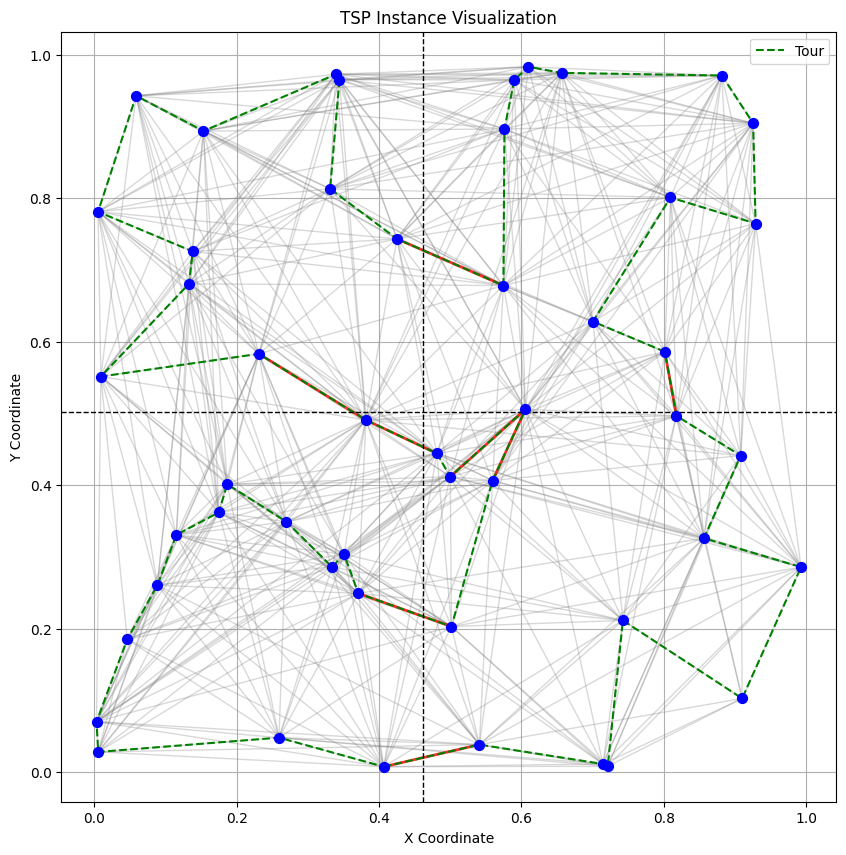

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tsp_instance(nodes_coord, edges, edges_target, x_mid, y_mid, tour_nodes=None):
    """
    Plots a single TSP instance with nodes, candidate edges, target edges, and midlines.

    Args:
        nodes_coord (np.ndarray): Coordinates of the nodes.
                                   Shape can be (num_nodes, 2) or (batch_size, num_nodes, 2).
        edges (np.ndarray): Adjacency matrix for candidate edges.
                            Shape can be (num_nodes, num_nodes) or (batch_size, num_nodes, num_nodes).
        edges_target (np.ndarray): Adjacency matrix for target edges.
                                   Shape can be (num_nodes, num_nodes) or (batch_size, num_nodes, num_nodes).
        x_mid (float or np.ndarray): Midpoint of the x-axis.
                                     Can be a scalar or array of shape (batch_size,).
        y_mid (float or np.ndarray): Midpoint of the y-axis.
                                     Can be a scalar or array of shape (batch_size,).
        tour_nodes (list or np.ndarray, optional): Order of nodes in the tour for visualization.
    """
    # Check if nodes_coord has a batch dimension
    if nodes_coord.ndim == 3:
        if nodes_coord.shape[0] == 1:
            # Extract the first (and only) instance from the batch
            nodes_coord = nodes_coord[0]
            edges = edges[0]
            edges_target = edges_target[0]
            if isinstance(x_mid, np.ndarray):
                x_mid = x_mid[0]
            if isinstance(y_mid, np.ndarray):
                y_mid = y_mid[0]
            if isinstance(tour_nodes, (list, np.ndarray)):
                tour_nodes = tour_nodes[0]
        else:
            raise ValueError("plot_tsp_instance currently only supports batch_size=1. "
                             "For larger batches, modify the function to handle multiple instances.")

    elif nodes_coord.ndim != 2:
        raise ValueError("nodes_coord must be either 2D (num_nodes, 2) or 3D (batch_size, num_nodes, 2).")

    # Validate the shapes
    num_nodes = nodes_coord.shape[0]
    if edges.shape != (num_nodes, num_nodes):
        raise ValueError(f"Expected edges shape ({num_nodes}, {num_nodes}), got {edges.shape}")
    if edges_target.shape != (num_nodes, num_nodes):
        raise ValueError(f"Expected edges_target shape ({num_nodes}, {num_nodes}), got {edges_target.shape}")

    # Debugging Information
    print(f"nodes_coord shape: {nodes_coord.shape}")
    print(f"x_mid: {x_mid}, y_mid: {y_mid}")
    if tour_nodes is not None:
        print(f"tour_nodes: {tour_nodes}")

    # Start plotting
    plt.figure(figsize=(10, 10))

    # Plot candidate edges (transparent grey)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if edges[i, j] == 1:
                plt.plot([nodes_coord[i, 0], nodes_coord[j, 0]],
                         [nodes_coord[i, 1], nodes_coord[j, 1]],
                         color='grey', alpha=0.3, linewidth=1)

    # Plot target edges (red)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if edges_target[i, j] == 1:
                plt.plot([nodes_coord[i, 0], nodes_coord[j, 0]],
                         [nodes_coord[i, 1], nodes_coord[j, 1]],
                         color='red', alpha=0.8, linewidth=2)

    # Plot nodes (blue)
    plt.scatter(nodes_coord[:, 0], nodes_coord[:, 1], color='blue', s=50, zorder=5)

    # Optionally, plot the tour
    if tour_nodes is not None:
        try:
            # Validate tour_nodes indices
            if not all(0 <= node < num_nodes for node in tour_nodes):
                raise IndexError("tour_nodes contains indices out of bounds.")

            # Extract coordinates of tour nodes
            tour_coords = nodes_coord[tour_nodes]

            # Append the first node to close the loop
            tour_coords = np.vstack([tour_coords, tour_coords[0]])

            plt.plot(tour_coords[:, 0], tour_coords[:, 1], color='green', linestyle='--', linewidth=1.5, label='Tour')
        except IndexError as e:
            print(f"Error plotting tour: {e}")
            print(f"tour_nodes: {tour_nodes}")
            print(f"nodes_coord shape: {nodes_coord.shape}")
            # Optionally, handle the error or skip plotting the tour

    # Plot midlines
    plt.axvline(x=x_mid, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=y_mid, color='black', linestyle='--', linewidth=1)

    # Labels and title
    plt.title("TSP Instance Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_tsp_instance(
            nodes_coord=batch.nodes_coord,
            edges=batch.edges,
            edges_target=batch.edges_target,
            x_mid=batch.x_mid,
            y_mid=batch.y_mid,
            tour_nodes=batch.tour_nodes
        )

In [9]:
#@title Batch normalization layers 
class BatchNormNode(nn.Module):
    """Batch normalization for node features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormNode, self).__init__()
        self.batch_norm = nn.BatchNorm1d(hidden_dim, track_running_stats=False)

    def forward(self, x):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)

        Returns:
            x_bn: Node features after batch normalization (batch_size, num_nodes, hidden_dim)
        """
        x_trans = x.transpose(1, 2).contiguous()  # Reshape input: (batch_size, hidden_dim, num_nodes)
        x_trans_bn = self.batch_norm(x_trans)
        x_bn = x_trans_bn.transpose(1, 2).contiguous()  # Reshape to original shape
        return x_bn


class BatchNormEdge(nn.Module):
    """Batch normalization for edge features.
    """

    def __init__(self, hidden_dim):
        super(BatchNormEdge, self).__init__()
        self.batch_norm = nn.BatchNorm2d(hidden_dim, track_running_stats=False)

    def forward(self, e):
        """
        Args:
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_bn: Edge features after batch normalization (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_trans = e.transpose(1, 3).contiguous()  # Reshape input: (batch_size, num_nodes, num_nodes, hidden_dim)
        e_trans_bn = self.batch_norm(e_trans)
        e_bn = e_trans_bn.transpose(1, 3).contiguous()  # Reshape to original
        return e_bn

In [10]:
#@title MLP layer
class MLP(nn.Module):
    """Multi-layer Perceptron for output prediction.
    """

    def __init__(self, hidden_dim, output_dim, L=2):
        super(MLP, self).__init__()
        self.L = L
        U = []
        for layer in range(self.L - 1):
            U.append(nn.Linear(hidden_dim, hidden_dim, True))
        self.U = nn.ModuleList(U)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        """
        Args:
            x: Input features (batch_size, hidden_dim)

        Returns:
            y: Output predictions (batch_size, output_dim)
        """
        Ux = x
        for U_i in self.U:
            Ux = U_i(Ux)  # B x H
            Ux = F.relu(Ux)  # B x H
        y = self.V(Ux)  # B x O
        return y

In [11]:
class NodeFeatures(nn.Module):
    """Convnet features for nodes.
    
    Using `sum` aggregation:
        x_i = U*x_i +  sum_j [ gate_ij * (V*x_j) ]
    
    Using `mean` aggregation:
        x_i = U*x_i + ( sum_j [ gate_ij * (V*x_j) ] / sum_j [ gate_ij] )
    """
    
    def __init__(self, hidden_dim, aggregation="mean"):
        super(NodeFeatures, self).__init__()
        self.aggregation = aggregation
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, edge_gate):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            edge_gate: Edge gate values (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
        """
        Ux = self.U(x)  # B x V x H
        Vx = self.V(x)  # B x V x H
        Vx = Vx.unsqueeze(1)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        gateVx = edge_gate * Vx  # B x V x V x H
        if self.aggregation=="mean":
            x_new = Ux + torch.sum(gateVx, dim=2) / (1e-20 + torch.sum(edge_gate, dim=2))  # B x V x H
        elif self.aggregation=="sum":
            x_new = Ux + torch.sum(gateVx, dim=2)  # B x V x H
        return x_new


class EdgeFeatures(nn.Module):
    """Convnet features for edges.

    e_ij = U*e_ij + V*(x_i + x_j)
    """

    def __init__(self, hidden_dim):
        super(EdgeFeatures, self).__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, hidden_dim, True)
        
    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        Ue = self.U(e)
        Vx = self.V(x)
        Wx = Vx.unsqueeze(1)  # Extend Vx from "B x V x H" to "B x V x 1 x H"
        Vx = Vx.unsqueeze(2)  # extend Vx from "B x V x H" to "B x 1 x V x H"
        e_new = Ue + Vx + Wx
        return e_new

In [12]:
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection.
    """

    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_in = e
        x_in = x
        # Edge convolution
        e_tmp = self.edge_feat(x_in, e_in)  # B x V x V x H
        # Compute edge gates
        edge_gate = torch.sigmoid(e_tmp)
        # Node convolution
        x_tmp = self.node_feat(x_in, edge_gate)
        # Batch normalization
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        # ReLU Activation
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        # Residual connection
        x_new = x_in + x
        e_new = e_in + e
        return x_new, e_new

In [13]:
class ResidualGatedGCNLayer(nn.Module):
    """Convnet layer with gating and residual connection.
    """

    def __init__(self, hidden_dim, aggregation="sum"):
        super(ResidualGatedGCNLayer, self).__init__()
        self.node_feat = NodeFeatures(hidden_dim, aggregation)
        self.edge_feat = EdgeFeatures(hidden_dim)
        self.bn_node = BatchNormNode(hidden_dim)
        self.bn_edge = BatchNormEdge(hidden_dim)

    def forward(self, x, e):
        """
        Args:
            x: Node features (batch_size, num_nodes, hidden_dim)
            e: Edge features (batch_size, num_nodes, num_nodes, hidden_dim)

        Returns:
            x_new: Convolved node features (batch_size, num_nodes, hidden_dim)
            e_new: Convolved edge features (batch_size, num_nodes, num_nodes, hidden_dim)
        """
        e_in = e
        x_in = x
        # Edge convolution
        e_tmp = self.edge_feat(x_in, e_in)  # B x V x V x H
        # Compute edge gates
        edge_gate = torch.sigmoid(e_tmp)
        # Node convolution
        x_tmp = self.node_feat(x_in, edge_gate)
        # Batch normalization
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        # ReLU Activation
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        # Residual connection
        x_new = x_in + x
        e_new = e_in + e
        return x_new, e_new

In [14]:
from torch_geometric.nn import TransformerConv

class ResidualGatedGCNModel(nn.Module):
    """Residual Gated GCN Model for outputting predictions as edge adjacency matrices.
    """

    def __init__(self, config):
        super(ResidualGatedGCNModel, self).__init__()
        #self.dtypeFloat = dtypeFloat
        #self.dtypeLong = dtypeLong
        # Define net parameters
        self.num_nodes = config['num_nodes']
        self.node_dim = config['node_dim']
        self.voc_nodes_in = config['voc_nodes_in']
        self.voc_nodes_out = config['num_nodes'] 
        self.voc_edges_in = config['voc_edges_in']
        self.voc_edges_out = config['voc_edges_out']
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.mlp_layers = config['mlp_layers']
        self.aggregation = config['aggregation']
        # Node and edge embedding layers/lookups
       
        # We are using TransformerConv layer from torch geometric library!
        self.nodes_coord_embedding = TransformerConv(self.node_dim, self.hidden_dim) 
      
        self.edges_values_embedding = nn.Linear(1, self.hidden_dim//2, bias=False)
        self.edges_embedding = nn.Embedding(self.voc_edges_in, self.hidden_dim//2)
        # Define GCN Layers
        gcn_layers = []
        for layer in range(self.num_layers):
            gcn_layers.append(ResidualGatedGCNLayer(self.hidden_dim, self.aggregation))
        self.gcn_layers = nn.ModuleList(gcn_layers)
        # Define MLP classifiers
        self.mlp_edges = MLP(self.hidden_dim, self.voc_edges_out, self.mlp_layers)

    def loss_edges(self, y_pred_edges, y_edges, edge_cw):
        """
        Loss function for edge predictions.

        Args:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss

        Returns:
            loss_edges: Value of loss function
        
        """
        # Edge loss
        y = F.log_softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
        y = y.permute(0, 3, 1, 2)  # B x voc_edges x V x V
        loss_edges = nn.NLLLoss(edge_cw)
        loss = loss_edges(y.contiguous(), y_edges)
        return loss

    def forward(self, x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw):
        """
        Args:
            x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
            x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
            x_nodes: Input nodes (batch_size, num_nodes)
            x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
            y_edges: Targets for edges (batch_size, num_nodes, num_nodes)
            edge_cw: Class weights for edges loss
            # y_nodes: Targets for nodes (batch_size, num_nodes, num_nodes)
            # node_cw: Class weights for nodes loss

        Returns:
            y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
            # y_pred_nodes: Predictions for nodes (batch_size, num_nodes)
            loss: Value of loss function
        """
        # Node and edge embedding
        edge_index = torch.squeeze(x_edges).nonzero().t().contiguous()
        x = self.nodes_coord_embedding(torch.squeeze(x_nodes_coord), edge_index)  
        x = torch.unsqueeze(x, 0)
        e_vals = self.edges_values_embedding(x_edges_values.unsqueeze(3))  # B x V x V x H
        e_tags = self.edges_embedding(x_edges)  # B x V x V x H
        e = torch.cat((e_vals, e_tags), dim=3)
        # GCN layers
        for layer in range(self.num_layers):
            x, e = self.gcn_layers[layer](x, e)  # B x V x H, B x V x V x H
        # MLP classifier
        y_pred_edges = self.mlp_edges(e)  # B x V x V x voc_edges_out
        
        # Compute loss
        edge_cw = torch.tensor(edge_cw, dtype=torch.float, device=device)
        loss = self.loss_edges(y_pred_edges.to(device), y_edges.to(device), edge_cw.to(device))
        
        return y_pred_edges, loss

In [15]:
#@title Hyperparameters

num_nodes = 50
num_neighbors = 20  # Could increase it!
train_filepath = f"tsp-data/tsp{num_nodes}_train_concorde.txt"
hidden_dim = 300  # @param
num_layers = 5     # @param
mlp_layers = 2     # @param
learning_rate = 0.001  # @param
max_epochs = 30         # @param
batches_per_epoch = 10000

variables = {
    'train_filepath': f"tsp-data/tsp{num_nodes}_train_concorde.txt",
    'val_filepath': f"tsp-data/tsp{num_nodes}_val_concorde.txt", 
    'test_filepath': f"tsp-data/tsp{num_nodes}_test_concorde.txt", 
    'num_nodes': num_nodes, 
    'num_neighbors': num_neighbors, 
    'node_dim': 2, 
    'voc_nodes_in': 2, 
    'voc_nodes_out': 2, 
    'voc_edges_in': 3, 
    'voc_edges_out': 2, 
    'hidden_dim': hidden_dim, 
    'num_layers': num_layers, 
    'mlp_layers': mlp_layers, 
    'aggregation': 'mean', 
    'max_epochs': max_epochs, 
    'val_every': 5, 
    'test_every': 5, 
    'batches_per_epoch': batches_per_epoch, 
    'accumulation_steps': 1, 
    'learning_rate': learning_rate, 
    'decay_rate': 1.01
}

# Set device to CPU explicitly
#device = torch.device('cpu')

# Initialize the model with CPU tensor types
# Replace ResidualGatedGCNModel with your actual model class
# Ensure that ResidualGatedGCNModel accepts tensor types as parameters
net = ResidualGatedGCNModel(variables)

net.to(device)

# Wrap the model with DataParallel to utilize both GPUs
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)  # Logical device indices after CUDA_VISIBLE_DEVICES
    print(f"Model is using {torch.cuda.device_count()} GPUs with DataParallel.")
else:
    print("Model is using a single GPU or CPU.")

# If you previously used DataParallel for GPU, it's generally unnecessary for CPU
# Removing DataParallel for simplicity and efficiency
# If you still wish to use it for multi-core CPU parallelism, consider alternative approaches
# net = nn.DataParallel(net)  # Removed for CPU implementation

# Compute the number of network parameters
nb_param = sum(np.prod(param.size()) for param in net.parameters())
print('Number of parameters:', nb_param)

Model is using a single GPU or CPU.
Number of parameters: 1907102


In [16]:
def train_one_epoch(net, optimizer, config):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config['num_nodes']
    num_neighbors = config['num_neighbors']
    batches_per_epoch = config['batches_per_epoch']
    accumulation_steps = config['accumulation_steps']
    train_filepath = config['train_filepath']

    # Load TSP data
    dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_nb_data = 0

    start_epoch = time.time()
    for batch_num in range(batches_per_epoch):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = torch.tensor(batch.edges, dtype=torch.long, device=device)
        x_edges_values = torch.tensor(batch.edges_values, dtype=torch.float, device=device)
        x_nodes = torch.tensor(batch.nodes, dtype=torch.long, device=device)
        x_nodes_coord = torch.tensor(batch.nodes_coord, dtype=torch.float, device=device)
        y_edges = torch.tensor(batch.edges_target, dtype=torch.long, device=device)
        y_nodes = torch.tensor(batch.nodes_target, dtype=torch.long, device=device)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Update running data
        running_nb_data += 1
        running_loss += loss.data.item()* accumulation_steps  # Re-scale loss
        
    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data

    return time.time()-start_epoch, loss

In [17]:
def test(net, config, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config['num_nodes']
    num_neighbors = config['num_neighbors']
    batches_per_epoch = 1 # config['batches_per_epoch']
    val_filepath = config['val_filepath']
    test_filepath = config['test_filepath']

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, filepath=test_filepath)

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_nb_data = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in range(batches_per_epoch):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = torch.tensor(batch.edges, dtype=torch.long, device=device)
            x_edges_values = torch.tensor(batch.edges_values, dtype=torch.float, device=device)
            x_nodes = torch.tensor(batch.nodes, dtype=torch.long, device=device)
            x_nodes_coord = torch.tensor(batch.nodes_coord, dtype=torch.float, device=device)
            y_edges = torch.tensor(batch.edges_target, dtype=torch.long, device=device)
            y_nodes = torch.tensor(batch.nodes_target, dtype=torch.long, device=device)
            
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Update running data
            running_nb_data += 1
            running_loss += loss.data.item()
            
    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data

    return time.time()-start_test, loss

def update_learning_rate(optimizer, lr):
  """
  Updates learning rate for given optimizer.

  Args:
      optimizer: Optimizer object
      lr: New learning rate

  Returns:
      optimizer: Updated optimizer objects
  """
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr
  return optimizer

In [18]:
# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=variables["learning_rate"])
val_loss_old = None

train_losses = []
val_losses = []
test_losses = []

for epoch in range(variables["max_epochs"]):
    # Train
    train_time, train_loss = train_one_epoch(net, optimizer, variables)
    # Print metrics
    train_losses.append(train_loss)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}")
    
    if epoch % variables["val_every"] == 0 or epoch == variables["max_epochs"]-1:
        # Validate
        val_time, val_loss = test(net, variables, mode='val')
        val_losses.append(val_loss)
        print(f"Epoch: {epoch}, Val Loss; {val_loss}")

        # Update learning rate
        if val_loss_old != None and val_loss > 0.99 * val_loss_old:
            variables["learning_rate"] /= variables["decay_rate"]
            optimizer = update_learning_rate(optimizer, variables["learning_rate"])
        
        val_loss_old = val_loss  # Update old validation loss

    if epoch % variables["test_every"] == 0 or epoch == variables["max_epochs"]-1:
        # Test
        test_time, test_loss = test(net, variables, mode='test')
        test_losses.append(test_loss)
        print(f"Epoch: {epoch}, Test Loss; {test_loss}\n")

Epoch: 0, Train Loss: 0.11252920982390642
Epoch: 0, Val Loss; 0.0864454060792923
Epoch: 0, Test Loss; 0.07670356333255768

Epoch: 1, Train Loss: 0.0833483016654849
Epoch: 2, Train Loss: 0.07393541590087116
Epoch: 3, Train Loss: 0.0697898567641154
Epoch: 4, Train Loss: 0.0670786519235
Epoch: 5, Train Loss: 0.06482927085813135
Epoch: 5, Val Loss; 0.06432867795228958
Epoch: 5, Test Loss; 0.09174761921167374

Epoch: 6, Train Loss: 0.06362665044926107
Epoch: 7, Train Loss: 0.06240880934391171
Epoch: 8, Train Loss: 0.06206851656343788
Epoch: 9, Train Loss: 0.06004730368983
Epoch: 10, Train Loss: 0.060901276415213944
Epoch: 10, Val Loss; 0.05740806460380554
Epoch: 10, Test Loss; 0.045697666704654694

Epoch: 11, Train Loss: 0.058233747336268425
Epoch: 12, Train Loss: 0.05828708631265909
Epoch: 13, Train Loss: 0.05791426227670163
Epoch: 14, Train Loss: 0.05741118729468435
Epoch: 15, Train Loss: 0.056689250970445575
Epoch: 15, Val Loss; 0.050549574196338654
Epoch: 15, Test Loss; 0.03657586127519

In [19]:
def plot_tsp_ground_truth_and_heatmap(nodes_coord, edges_target, edges_pred_probs, x_mid, y_mid, title="TSP Visualization"):
    """
    Plots ground truth edges and prediction heatmap for a single TSP instance.
    
    Args:
        nodes_coord (np.ndarray): Coordinates of the nodes. Shape: (num_nodes, 2)
        edges_target (np.ndarray): Ground truth adjacency matrix. Shape: (num_nodes, num_nodes)
        edges_pred_probs (np.ndarray): Predicted adjacency matrix with probabilities. Shape: (num_nodes, num_nodes)
        x_mid (float): Midpoint of the x-axis.
        y_mid (float): Midpoint of the y-axis.
        title (str): Title of the plot.
    """
    num_nodes = nodes_coord.shape[0]
    
    # Validate input shapes
    if edges_pred_probs.shape != (num_nodes, num_nodes):
        raise ValueError(f"edges_pred_probs must be of shape ({num_nodes}, {num_nodes}), but got {edges_pred_probs.shape}")
    if edges_target.shape != (num_nodes, num_nodes):
        raise ValueError(f"edges_target must be of shape ({num_nodes}, {num_nodes}), but got {edges_target.shape}")
    
    # Debugging Information
    print(f"nodes_coord shape: {nodes_coord.shape}")
    print(f"edges_target shape: {edges_target.shape}")
    print(f"edges_pred_probs shape: {edges_pred_probs.shape}")
    print(f"x_mid: {x_mid}, y_mid: {y_mid}")
    
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Define a normalization for the heatmap colors
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Assuming probabilities are between 0 and 1
    cmap = plt.cm.Reds  # Continuous shades of red
    
    # ---------------------------------
    # Left Plot: Ground Truth Edges
    # ---------------------------------
    ax = axes[0]
    ax.set_title("Ground Truth Edges", fontsize=16)
    
    # Plot nodes
    ax.scatter(nodes_coord[:, 0], nodes_coord[:, 1], color='blue', s=50, zorder=5)
    
    # Plot ground truth edges
    lines = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if edges_target[i, j] == 1:
                lines.append([nodes_coord[i], nodes_coord[j]])
    
    if lines:
        lc = LineCollection(lines, colors='red', linewidths=2, alpha=0.8)
        ax.add_collection(lc)
    
    # Plot midlines
    ax.axvline(x=x_mid, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=y_mid, color='black', linestyle='--', linewidth=1)
    
    ax.set_xlabel("X Coordinate", fontsize=14)
    ax.set_ylabel("Y Coordinate", fontsize=14)
    ax.grid(True)
    ax.set_aspect('equal')
    
    # ---------------------------------
    # Right Plot: Prediction Heatmap
    # ---------------------------------
    ax = axes[1]
    ax.set_title("Prediction Heatmap", fontsize=16)
    
    # Plot nodes
    ax.scatter(nodes_coord[:, 0], nodes_coord[:, 1], color='blue', s=50, zorder=5)
    
    # Prepare edges and their corresponding probabilities
    lines = []
    colors = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            prob = edges_pred_probs[i, j]
            lines.append([nodes_coord[i], nodes_coord[j]])
            colors.append(prob)
    
    # Convert to NumPy arrays for sorting
    lines = np.array(lines)        # Shape: (num_edges, 2, 2)
    colors = np.array(colors)      # Shape: (num_edges,)
    
    # Sort edges by probability in ascending order
    sorted_indices = np.argsort(colors)
    lines_sorted = lines[sorted_indices]
    colors_sorted = colors[sorted_indices]
    
    # Debugging: Check the shape of colors
    print(f"Colors array shape after sorting: {colors_sorted.shape}")  # Should be (num_edges,)
    
    # Create a LineCollection with sorted edges
    lc = LineCollection(lines_sorted, cmap=cmap, norm=norm, linewidths=1.5)
    lc.set_array(colors_sorted)
    lc.set_alpha(0.8)
    ax.add_collection(lc)
    
    # Add a colorbar
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Edge Probability', fontsize=14)
    
    # Plot midlines
    ax.axvline(x=x_mid, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=y_mid, color='black', linestyle='--', linewidth=1)
    
    ax.set_xlabel("X Coordinate", fontsize=14)
    ax.set_ylabel("Y Coordinate", fontsize=14)
    ax.grid(True)
    ax.set_aspect('equal')
    
    # Set overall title
    fig.suptitle(title, fontsize=20)
    
    plt.show()

nodes_coord shape: (50, 2)
edges_target shape: (50, 50)
edges_pred_probs shape: (50, 50)
x_mid: 0.47756243147670197, y_mid: 0.46212922151281405
Colors array shape after sorting: (1225,)


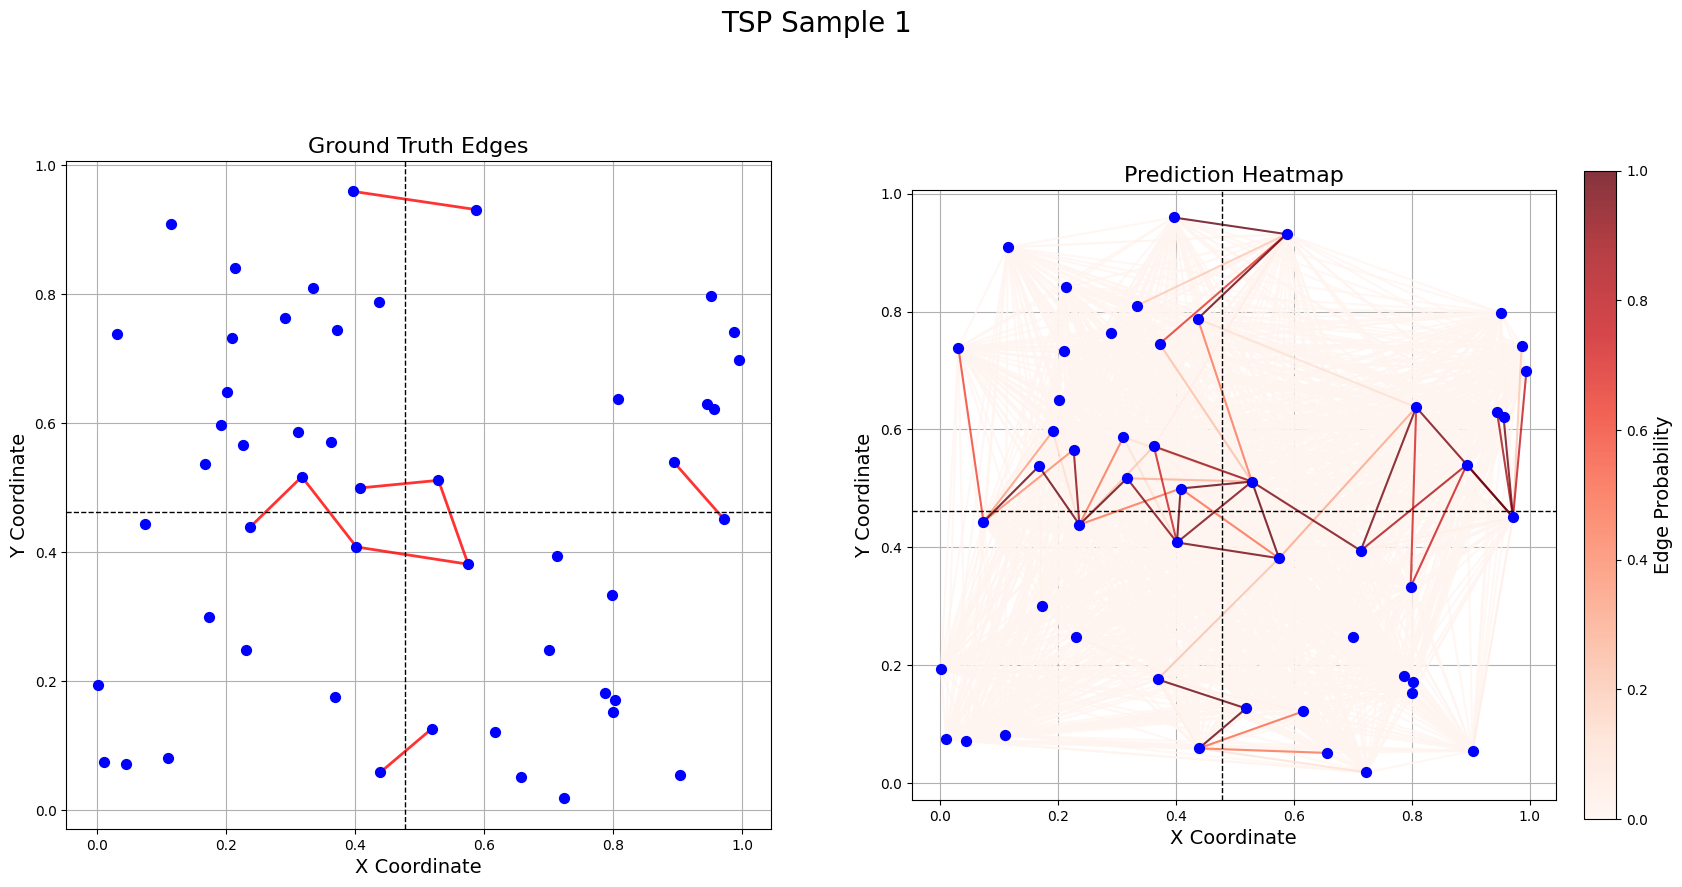

nodes_coord shape: (50, 2)
edges_target shape: (50, 50)
edges_pred_probs shape: (50, 50)
x_mid: 0.5345169730621945, y_mid: 0.4712873850011296
Colors array shape after sorting: (1225,)


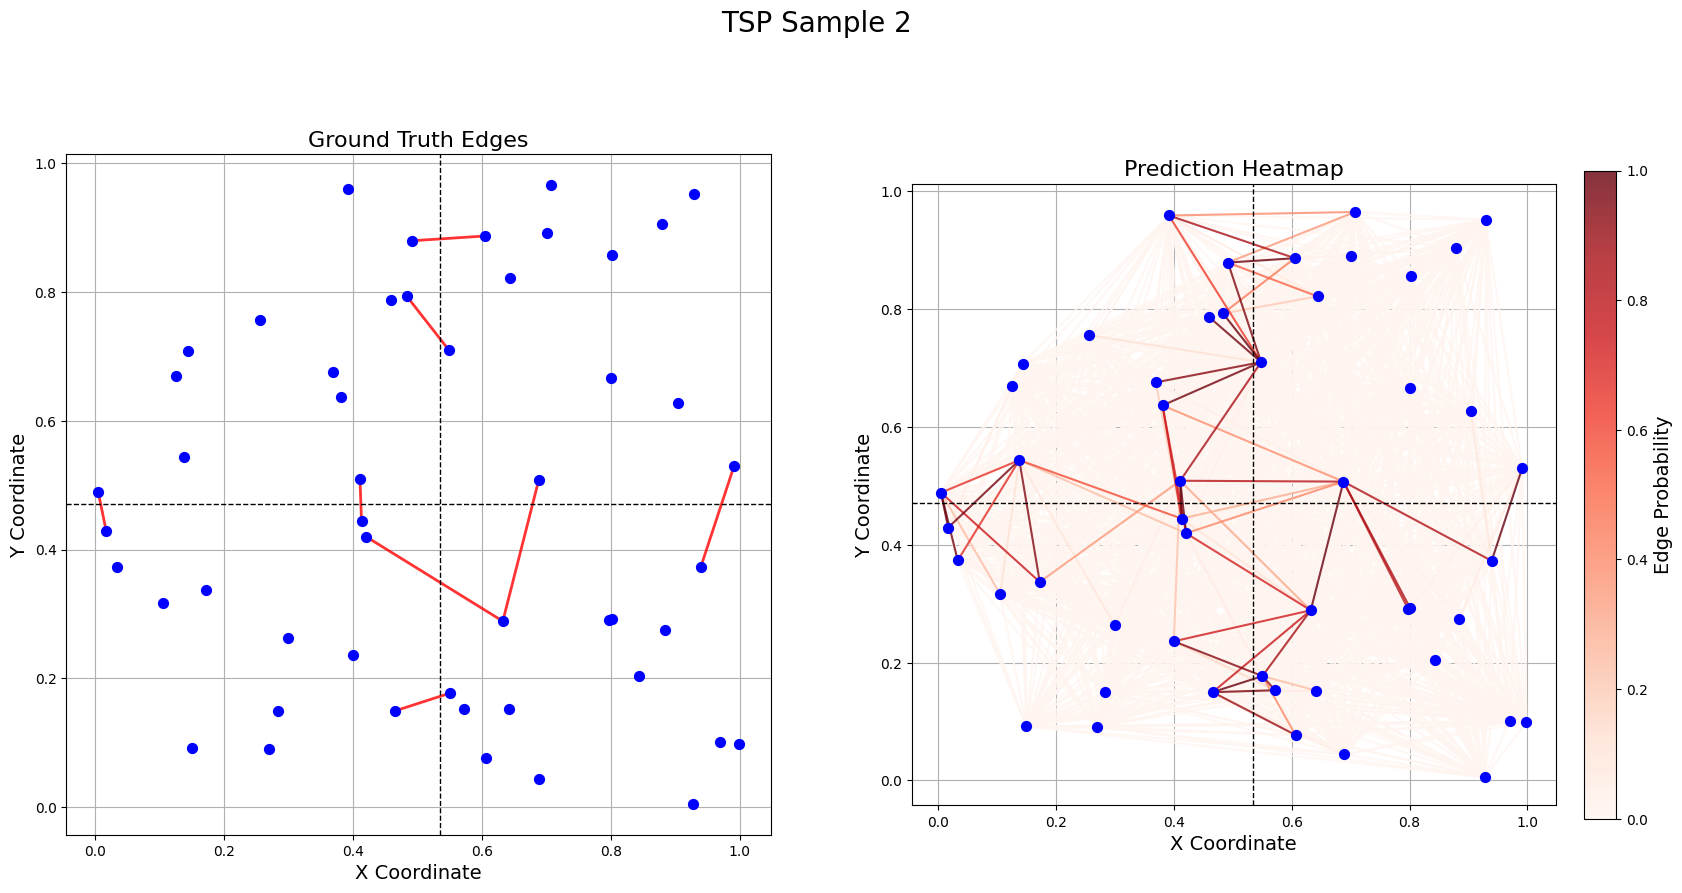

In [20]:
net.eval()

# Number of test samples to visualize
num_samples = 2  # Adjust as needed

# Extract relevant variables
num_nodes = variables['num_nodes']
num_neighbors = variables['num_neighbors']
test_filepath = variables['test_filepath']

# Initialize the test dataset
test_dataset = GoogleTSPReader(num_nodes, num_neighbors, 1, test_filepath)
test_iter = iter(test_dataset)

# Iterate over the specified number of test samples
for sample_idx in range(num_samples):
    try:
        # Get a single test sample
        batch = next(test_iter)
    except StopIteration:
        print("No more samples in the test dataset.")
        break
    
    # Convert batch to torch tensors and move to device
    # Assuming batch_size=1
    x_edges = torch.tensor(batch.edges, dtype=torch.long, device=device)
    x_edges_values = torch.tensor(batch.edges_values, dtype=torch.float, device=device)
    x_nodes = torch.tensor(batch.nodes, dtype=torch.long, device=device)
    x_nodes_coord = torch.tensor(batch.nodes_coord, dtype=torch.float, device=device)
    y_edges = torch.tensor(batch.edges_target, dtype=torch.long, device=device)
    y_nodes = torch.tensor(batch.nodes_target, dtype=torch.long, device=device)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw_np = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    edge_cw = torch.tensor(edge_cw_np, dtype=torch.float, device=device)
    
    # Forward pass to get predictions
    with torch.no_grad():
        y_pred, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        # Apply softmax to get probabilities
        y_pred_probs = torch.softmax(y_pred, dim=3)  # Shape: (1, 50, 50, 2)
        # Extract Class 1 probabilities (edge in tour)
        y_pred_probs = y_pred_probs[:, :, :, 1]  # Shape: (1, 50, 50)
        y_pred_probs = y_pred_probs.squeeze(0)  # Shape: (50, 50)
        y_pred_probs_np = y_pred_probs.cpu().numpy()  # Shape: (50, 50)
    
    # Move ground truth to CPU for plotting
    y_edges_cpu = y_edges.squeeze(0).cpu().numpy()  # Shape: (50, 50)
    nodes_coord_cpu = x_nodes_coord.squeeze(0).cpu().numpy()  # Shape: (50, 2)
    
    # Extract midpoints
    # Assuming batch.x_mid and batch.y_mid are available and are lists or numpy arrays
    # If not, compute the mean of node coordinates
    if hasattr(batch, 'x_mid') and hasattr(batch, 'y_mid'):
        x_mid = batch.x_mid[0] if isinstance(batch.x_mid, (list, np.ndarray, torch.Tensor)) else batch.x_mid
        y_mid = batch.y_mid[0] if isinstance(batch.y_mid, (list, np.ndarray, torch.Tensor)) else batch.y_mid
    else:
        x_mid = np.mean(nodes_coord_cpu[:, 0])
        y_mid = np.mean(nodes_coord_cpu[:, 1])
    
    # Define a title for the plot
    plot_title = f"TSP Sample {sample_idx + 1}"
    
    # Plot ground truth and prediction heatmap
    plot_tsp_ground_truth_and_heatmap(
        nodes_coord=nodes_coord_cpu,
        edges_target=y_edges_cpu,
        edges_pred_probs=y_pred_probs_np,
        x_mid=x_mid,
        y_mid=y_mid,
        title=plot_title
    )

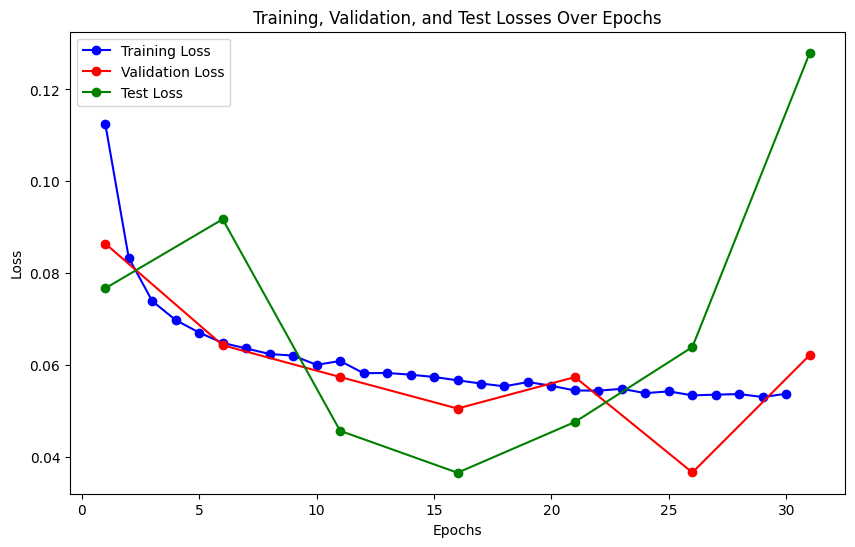

In [23]:
epochs = range(1, len(train_losses) + 1)
val_test_epochs = range(1, len(train_losses) + 2, 5)

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot each loss curve
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')   # 'bo-' means blue color, circle markers, solid line
plt.plot(val_test_epochs, val_losses, 'ro-', label='Validation Loss')   # 'ro-' means red color, circle markers, solid line
plt.plot(val_test_epochs, test_losses, 'go-', label='Test Loss')         # 'go-' means green color, circle markers, solid line

# Adding title and labels
plt.title('Training, Validation, and Test Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend to differentiate the curves
plt.legend()

# Display the plot
plt.show()